# Generation of Captions from Images

Tianyuan Cai

**Documentation Requirements:**

**Project summary (Abstract)**

One page Word document in a separate file. Project summary should contain your name /team,  title of your project and URLs to YouTube video.
Produce a one page summary to describe the problem you are trying to solve, your data set, the particular technology topic or feature you are demonstrating, its uses, benefits, drawbacks, challenges and your results.  Describe briefly the working example you prepared. This first page is very important. Based on that page, your colleagues will judge whether to download your project and spend time reading your documentation and code. Please add YouTube / reference URLs  to the bottom of the one page summary. 

Filenames should be prefixed with team if appropriate and then topic (abbreviate project), followed by your name:
	- you must identify and list all team members in all of your FP files
	- you must prefix your final zip with label "Team" e.g. Team_ShortTopicName_YourLastNameYourFirstName_Final.zip

**Demo/solution implementation and working code (python notebook)**

Produce a single working demo that meets your problem statement and provides a full implementation of your solution.  You may not simply copy examples (demonstrations) of the technology that are online. (Grade will be 0).  You can use code skeletons that are provided as we have done in class and show your extended programming use of them.  Provide neatly organized and complete working code with comments. Please note that a project will not be given any points if a working implementation and code are missing. Please provide the URL to your full data source. If your data set is larger than 10MB, PLEASE DO NOT UPLOAD your data set. In such a case, please provide only a sample of your data with the rest of your submission. Our site has a limited capacity and a few large submissions could block it.
PLEASE, PLEASE do not upload final projects which take more than 20 MB of space. In the past we had students who would upload GBs of data and block Canvas site. We do not find such practical jokes amusing.

**Slides**

Produce a set of Power Point slides (10-20) with a few snapshots of your demo which captures the key points: your problem statement, what the technology does, your demonstration and pros/cons. The first page of your Power Point slide must have a standard format that we provide.  Please use white background for all your Power Point slides. White background makes slides readable, printable and presentable on YouTube. Place URLs of your YouTube videos on the last slide.  Note: The filename should start with the topic name followed by your name

**Report**

Produce a detailed document with a complete description of analyzed technology or use case including all installation and configuration steps. Your report will start with your name and project title. Detailed installations and configuration is required. Your colleagues must be able to reproduce your work based solely on the steps you have documented.  Describe your problem statement, data set, installation/configuration, results, what worked, what did not and why not, and any lessons learned. Report must show all steps to reproduce examples that you developed.  This report is similar to your homework solutions where all steps are described along with the results.
* The first page of your report should be the same as the one page summary (abstract). The first page should contain your name /  team (as appropriate list all team members) and the project topic name. 
* Please include your name and your project topic in the header or the footer of your MS Word Document. 
* Name your file like you named 1 page summary appended with `_report`.
* Please include page numbers. 
* You are welcome to upload a PDF version of all documents. However, you must always submit an MS Word version of your report. Just submitting a Jupyter notebook is not acceptable. You must create a written report in MS Word.
* Please include URLs for your YouTube videos at the end of your report

**2-minute YouTube presentation**

Produce a 2 minute YouTube presentation. This video will contain a summary of the technology and a quick overview of your demonstration. This video might get presented to the entire class so please make sure it is 2 minutes and not more. 

**Submission Instructions: **

`Image_Captioning_CaiTianyuan_Final.zip`
* Submit final project on the course site. 
* Files to be submitted
	- Report, by itself
	- Slides, by itself
	- Code and surrounding artifacts, in a ZIP file
		- viz in a separate folder
	- Data files, in a separate ZIP file

Grading criteria:
If you fail to provide working code submitted in working directories with all artifacts it produces and (toy-sample) dataset, your project will not be graded. 

All other artifacts: Report, One page summary, PPTs are uploaded separately.

Assuming code is submitted:
* 50%, Project Report and practical software code example
* 25%, PowerPoint Slides
* 15%, 2 minute YouTube video
* 10%, One page summary

# Solution Implementation

## Overview

The goal of the project is to generate sensible captions for images. Image captioning has a large variety of applications. By understanding common objects in an image, and transforming them into text information, we can compress large photographic infomation into more compact data formats. This ability can be applied in a wide range of fields such as voice over technologies, product recommendation, etc. 

In this project, I utilize the Inception V3 model, GloVe embeddings, together with CNN and LSTM structures to produce captions. The training and validation data come from Common Objects in Context (COCO) dataset. In the following document, I will go through the setup, data preparation, model training, model validation, and discussion of the prediction results and potential for improvements.

## Preparing Environment

I start by installing packages that do not commonly come with Anaconda. This particular program uses tensorflow-gpu on a Titan Xp GPU. The `tqdm` package might be needed when loading encoded images on a computer with limited memory. 

The environment I use is tensorflow_gpu environment set up by Anaconda. Perform the following steps to ensure the code runs smoothly:

* Use the following code to download an dinstall all the necessary packages and dependencies. 
* Data set used by this code will all be created in the project folder. Look for the line `data_dir = "/home/tcai/Documents/nlp/final_project"`, and change this directory into yours. 
* The model training is done on a Titan Xp GPU with Cuda enabled. The training takes a long time. 

In [293]:
!pip install pillow numpy scikit-image keras Cython pycocotools nltk seaborn

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/tcai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tcai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/tcai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [403]:
import os
import pickle
from time import time
import json
import re

from pycocotools.coco import COCO
import sklearn
import keras
import pydot
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
import keras.applications.imagenet_utils
from PIL import Image
import tensorflow as tf

import skimage.io as io
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
import pylab
pylab.rcParams['figure.figsize'] = (4, 6)
from keras.applications.inception_v3 import preprocess_input

import nltk
from nltk.stem import WordNetLemmatizer

In [295]:
# Test if running on GPU
keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Data

### Data Overview

The data source used for this analysis is called COCO, common objects in context. See [Coco API](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) for package usage. 

COCO dataset provides a set of images that identifies common objects in context. The data include both images and captions that describes the objects and their context.

We start by extracting image and caption (annotation) data from COCO website. 

In [296]:
data_dir = "/home/tcai/Documents/nlp/final_project"
data_type = "train2017"
data_zipfile = '%s.zip'%(data_type)

Run the following command only once to obtain and extract files. If the files already exist, remove them to ensure the `get_file` commands can run smoothly.

In [297]:
# annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                          cache_subdir=os.path.abspath('.'),
#                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
#                                          extract = True)
# image_zip = tf.keras.utils.get_file(data_zipfile,
#                                     cache_subdir=os.path.abspath('.'),
#                                     origin = 'http://images.cocodataset.org/zips/%s'%(data_zipfile),
#                                     extract = True)
# glove6b_zip = tf.keras.utils.get_file('glove.6B.zip',
#                                     cache_subdir=os.path.abspath('./glove6b'),
#                                     origin = 'http://nlp.stanford.edu/data/glove.6B.zip',
#                                     extract = True)

In [298]:
# Annotation file
annotation_file = data_dir + '/annotations/captions_%s.json'%(data_type)
image_dir = data_dir+'/%s/'%(data_type)

Coco provides images that are categorized into a variety of categories. The categories listed below can be used to index images in the data set.

In [299]:
# Initialize COCO api for instance annotations
coco_caps=COCO(annotation_file)

# Obtain categories
annFile='{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('\nCOCO Categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO Supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loading annotations into memory...
Done (t=9.28s)
creating index...
index created!

COCO Categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO Supercategories: 
food furniture person outdoor appliance kitchen electronic animal indoor vehicle sports accessory


COCO API has a handy feature that allows the user to see images by custom categories. For instance, when inputing the feature `['dog','person', 'ball']`, here is what the model shows.

The index of the chosen image is 106484.

The corresponding captions are:
A man walking a dalmatian on a red leash.
The man has a red leash on his Dalmatian dog.
a man walks a dog with a leech 
A guy is walking his dalmatian down the road. 
A man walking a dalmatian on leash in front of a firetruck.


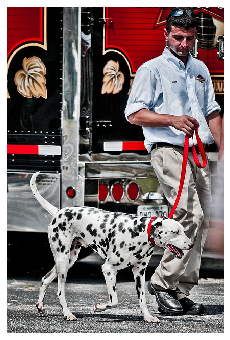

In [300]:
# Show sample data set by choosing categories
temp_cat = ['dog','person', 'ball']

catIds = coco.getCatIds(catNms=temp_cat)
imgIds = coco.getImgIds(catIds=catIds)

if len(imgIds) > 0:
    imgIds = coco.getImgIds(imgIds = imgIds[-1]) # Pick the last image
    print("The index of the chosen image is %s.\n"%(str(imgIds[0])))
else:
    print("No matched images found.")

# load and display captions
annIds = coco_caps.getAnnIds(imgIds)
anns = coco_caps.loadAnns(annIds)
print("The corresponding captions are:")
coco_caps.showAnns(anns)

# Show image
img = coco.loadImgs(imgIds)[0]
I = io.imread('%s/%s/%s'%(data_dir,data_type,img['file_name']))
plt.imshow(I); plt.axis('off'); plt.show()

### Train-test Split

Captions, images paths, and encoded image features are needed in order to effectively implemented the training. Rather than using `train_test_split` function, I choose to shuffle the data and subset to the desired number of train and test samples.

In [301]:
# TODO: Change this to a smaller value during submission
total_examples = 100000
train_examples = int(0.8 * total_examples)

# Subset training and testing images
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_img_path_vector = {}
all_img_name_vector = list(set([x['image_id'] for x in annotations['annotations']]))
print("Choosing %s training images and %s validation images from a total of %s images"%(train_examples, total_examples - train_examples, len(all_img_name_vector)))

for img_id in all_img_name_vector:
    img = coco.loadImgs(img_id)[0]
    image_file_path = '%s/%s/%s'%(data_dir,data_type,img['file_name'])
    all_img_path_vector[img_id] = image_file_path
    
all_img_name_vector = sklearn.utils.shuffle(all_img_name_vector, random_state = 0)
all_img_name_vector = all_img_name_vector[:total_examples] # subset

train_img_name_vector = all_img_name_vector[:train_examples] # train
test_img_name_vector = all_img_name_vector[train_examples:] # test

Choosing 80000 training images and 20000 validation images from a total of 118287 images


## Extract Image Features

I use a pre-trained model, Inception-V3 model, to encode images such that we obtained the feature vectors of the image. I took out the final fully-connected layer in order to pass the features along to the image captioning model. When encoding, note that hash table is used to ensure I am encoding distinct images. This is because one image has multiple captions associated with it.

### Image Encoder

In [302]:
# https://keras.io/applications/#inceptionv3
# feature_model = keras.applications.inception_v3.InceptionV3(weights='imagenet')
image_model = keras.applications.InceptionV3(weights='imagenet')
feature_model = keras.models.Model(image_model.input, image_model.layers[-2].output)

Define encoding function that:
* Transform the image into consistent sizes
* Convert the images to array
* Expand dimensions
* Preprocess the input
* Reshape images

In [303]:
# Encoding function for feature extraction
def encode(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    fea_vec = feature_model.predict(img_array)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return(fea_vec)

In [304]:
# Testing image model
def inceptionv3_predict(image_path, image_model):
#     image_path = '/home/tcai/Documents/nlp/final_project/train2017/000000262145.jpg'
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    preds = image_model.predict(img_array)
    P = keras.applications.imagenet_utils.decode_predictions(preds)
    
    # Show prediction result
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))
    
    # Show image
    I = io.imread(image_path)
    plt.imshow(I); plt.axis('off'); plt.show()

The Inception V3 model is able to recoginize objects in a given image. 

1. freight_car: 40.83%
2. passenger_car: 29.35%
3. electric_locomotive: 5.97%
4. steam_locomotive: 1.17%
5. mobile_home: 0.59%


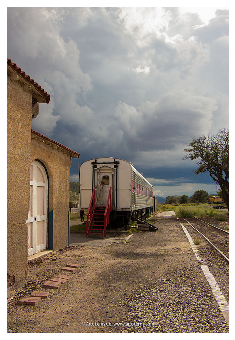

In [305]:
random_img_id = np.random.choice(all_img_name_vector)
random_img_path = all_img_path_vector[random_img_id]
inceptionv3_predict(random_img_path, image_model)

Encode images and then store the encoded image features in a pickle file to be loaded for future uses. The following code takes around 2100 seconds on the Titan Xp GPU. Please only run the code once to store the results.

In [306]:
# # Encode all the train images
# start = time()
# train_features = {}
# for img_id in all_img_name_vector:
#     train_features[img_id] = encode(all_img_path_vector[img_id])

# print("Time taken in seconds =", time() - start)

# # Pickle the features
# with open(data_dir + "/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(train_features, encoded_pickle)

In [307]:
train_features = pickle.load(open(data_dir + "/encoded_train_images.pkl", "rb"))
print('%d photos in total are encoded. These include both training and testing image set.' % len(train_features))

100000 photos in total are encoded. These include both training and testing image set.


For each captions in the training and testing data set, I append images back onto the captions so that all captions and features are included.

In [308]:
# Train images
captions = []
images = []
images_features = []

for img_id in train_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))
    
    for caption in [x['caption'] for x in img_captions]:
        captions.append('start_sentence ' + caption + ' end_sentence')
        images.append(img_path)
        images_features.append(img_feature)

captions, images, images_features = sklearn.utils.shuffle(captions, images, images_features, random_state = 0)

In [309]:
# Test images
test_captions = []
test_images = []
test_images_features = []

for img_id in test_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))
    
    for caption in [x['caption'] for x in img_captions]:
        test_captions.append('start_sentence ' + caption + ' end_sentence')
        test_images.append(img_path)
        test_images_features.append(img_feature)

test_captions, test_images, test_images_features = sklearn.utils.shuffle(test_captions, 
                                                                         test_images, 
                                                                         test_images_features, 
                                                                         random_state = 0)

In [310]:
print('Training: %s distinct images, %s captions,'%(len(list(set(images))), 
                                                    len(captions)))
print('Validation: %s distinct images, %s captions.'%(len(list(set(test_images))),
                                                      len(test_captions)))

Training: 80000 distinct images, 400204 captions,
Validation: 20000 distinct images, 100057 captions,


## Word Embeddings

In [311]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [312]:
number_of_words = 6000
# Choose the top words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words= number_of_words, oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~ ')
captions = [caption.lower() for caption in captions]
tokenizer.fit_on_texts(captions)

In [313]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

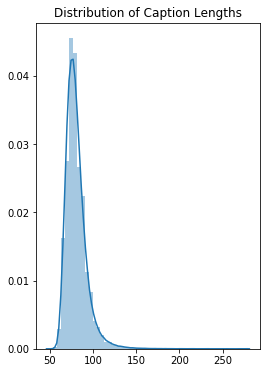

In [314]:
sentence_lengths = [len(caption) for caption in captions]
plt.title('Distribution of Caption Lengths')
sns.distplot(sentence_lengths)

Vector Representations with GloVe

Global Vectors for Word Representatiion (GloVe) is used to obtain embedding vectors for words in the captions. Pre-trained embedding is used to save time and ensure accuracy.

In [315]:
# Calculates sentence and vocab lengths
# max_length = calc_max_length(train_seqs)
max_length = 100   # This can be changed later
vocab_size = len(tokenizer.index_word)
print("Original max sentence length is %s; I set it to %s."%(calc_max_length(captions), max_length))
print("The vocabulary size is: %s"%(vocab_size))

Original max sentence length is 278; I set it to 100.
The vocabulary size is: 23636


The `glove.6B.300d.txt` file obtaiend at the beginning of the notebook is used here. 

In [316]:
embedding_dim = 300
embeddings_index = {}

with open(data_dir + '/glove6b/glove.6B.%sd.txt'%(embedding_dim), encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [317]:
# Get dense vector
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in (tokenizer.word_index).items():
    # All 0 is words not found in the embedding index
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [318]:
embedding_matrix.shape

(23636, 300)

## Model

The original model framework used here is inspired by various online blog posts and tutorials on similar projects. The use of Inception V3 and for image encoding is inspired by the paper [Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf).

In [319]:
# Extract features
inputs1 = tf.keras.Input(shape=(2048,))
fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
# Sequence model
inputs2 = tf.keras.Input(shape=(max_length,))
se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = tf.keras.layers.Dropout(0.5)(se1)
se3 = tf.keras.layers.LSTM(256)(se2)
# Decoder model
decoder1 = tf.keras.layers.Add()([fe2, se3])
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
# Final model
model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

Set weight using the glove embedding matrix

In [320]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [321]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [323]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     7090800     input_10[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

### Training

This function is used to generate a sequence of text as input and output. The generated sequences are then past into data generator and used for caption predictions. The `generate_sequences` function allows the model to perform word-by-word caption generation.

In [324]:
def generate_sequences(tokenizer, max_length, caption, image_feature):
    Ximages, XSeq, y = list(), list(),list()
    vocab_size = len(tokenizer.word_index)
    seq = tokenizer.texts_to_sequences([caption])[0]
    # split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # select
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = tf.keras.preprocessing.sequence.pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
        # encode output sequence
        out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]

        image_feature = np.squeeze(image_feature)
        Ximages.append(image_feature)
        XSeq.append(in_seq)
        y.append(out_seq)
    Ximages, XSeq, y = np.array(Ximages), np.array(XSeq), np.array(y)
    return [Ximages, XSeq, y]

Create Python data generator object to loop through all images. Use batch size to batch images and their corresponding caption sequences together before `yielding` to the `fit generator`.

In [325]:
# Python data generator object to loop through all images
def data_generator(tokenizer, max_length, captions, images_features, batch_size):
    n = 0
    while True:
        for i in range(len(captions)):
            in_img_vector = []
            in_seq_vector = []
            out_word_vector = []
            # load an image from file
            image_feature = images_features[i]
            # create word sequences
            caption = captions[i]
            in_img, in_seq, out_word = generate_sequences(tokenizer, max_length, caption, image_feature)
            in_img_vector.append(in_img)
            in_seq_vector.append(in_seq)
            out_word_vector.append(out_word)
            n += 1
            if n == batch_size:
                n = 0
                yield [in_img, in_seq], out_word

In [326]:
# Predict caption
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'start_sentence'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length, padding='post')
        
        photo = photo.reshape(2048,1).T
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end_sentence':
            break

    in_text = re.sub(r'(start|end)_sentence', '', in_text).strip()
    return in_text

In [327]:
# Store defautl weights
model_directory = './model'

if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    
model.save_weights(model_directory + '/model.h5')

Reset model weights to default

In [329]:
# Reset model with default weights before training
model.load_weights(model_directory + '/model.h5')

I used a fit generator because it is difficult to store $10,000$ images in the memory.

In [330]:
# Specify final model parameters
# After trying out different batch sizes, chose the one that proviided the most reasonable results
training_record = {}
epochs = 50
batch_size = 500
steps = len(captions)//batch_size
training_record[batch_size] = []
epoch_idx = 0

In [331]:
# Create dictionary to store loss values. Need this because using fit generator
loss = {}

In [332]:
# Use fit generator due to limited memory.
while epoch_idx <= epochs:
    generator = data_generator(tokenizer, max_length, captions, images_features, batch_size)
    history = model.fit_generator(generator, steps_per_epoch=steps, verbose=1)
    loss[epoch_idx] = history.history['loss']
    model.save_weights(model_directory + '/model_epoch%s_bs%s.h5'%(epoch_idx, batch_size))
    
    epoch_idx += 1

    distinct_desc = []
    temp_desc = ''
    for j in range(20):
        img_desc = generate_desc(model, tokenizer, images_features[j], max_length)
        distinct_desc.append(img_desc)
        temp_desc += '' + img_desc

    training_record[batch_size].append(distinct_desc)
    print("Model %s generated %s distinct captions with %s distinct words."%(epoch_idx, 
                                                                             len(list(set(distinct_desc))),
                                                                             len(list(set(temp_desc.split(' '))))))

At the first few epochs of the model training process, the model exhibits underfitting behavior where no distinct captions are generated. By understanding the number of distinct captions generated for a list of 20 images, I seek to approximate the appeal the model has for a human reader. In addition, as a model continues to learn from the training data, it becomes capable of generating more vocabularies as well.

In [333]:
plt.title('Model Training Loss')

loss_lists = sorted(loss.items()) # sorted by key, return a list of tuples
x, y = zip(*loss_lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Sample prediction of the model with a batch size of 500 and 50 epochs.

Predicted Caption: a bathroom with sink toilet rug and windows 
Actual Caption:  A plain white restroom toilet appointment in corner 
Resulting BLEU-4 score is 1.3509119634545632e-231


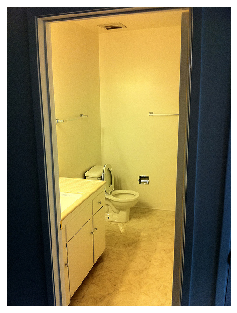

Predicted Caption: a close up of a person using a cart and his shadow 
Actual Caption:  A man on a bike in a station 
Resulting BLEU-4 score is 1.1522277201606316e-231


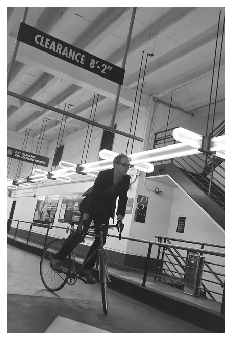

Predicted Caption: a man flies a kite on the beach 
Actual Caption:  A surfer is boarding through a wave in the ocean. 
Resulting BLEU-4 score is 1.4370213204318094e-231


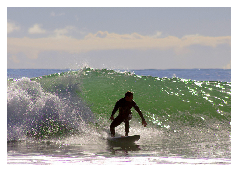

Predicted Caption: a single flower sitting in a little square vase 
Actual Caption:  A can is looking out of a red painted window. 
Resulting BLEU-4 score is 1.3459095292012048e-231


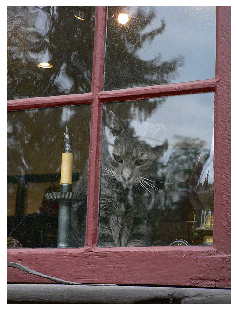

Predicted Caption: we are looking at a bench carved from a log 
Actual Caption:  A metallic refrigerator freezer sitting next to wooden cabinets. 
Resulting BLEU-4 score is 1.422889600764165e-231


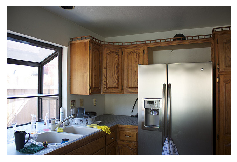

In [419]:
# Train images
print("Sample prediction of the model with a batch size of %s and %s epochs.\n"%(batch_size, epochs))

model.load_weights(model_directory + '/model_epoch%s_bs%s.h5'%(epochs, batch_size))

# Output prediction for the first five images in the validation data. Note that the data set is already shuffled.
for j in np.random.choice(range(len(test_captions)), 5):
    # Compare captions
    img_desc = generate_desc(model, tokenizer, test_images_features[j], max_length)
    actual_caption = test_captions[j]
    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)

    print("Predicted Caption: %s \nActual Caption: %s"%(img_desc, actual_caption))
    result_bleu = nltk.translate.bleu_score.sentence_bleu(actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s"%(result_bleu))
    # Show image
    I = io.imread(test_images[j])
    plt.imshow(I); plt.axis('off'); plt.show()

### Tuning

A wide range of parameters in the model can be tuned. Due to the limited computation resources and methods for tuning with fit generator, I tuned the batch size. If I have more time, I will also tune the drop out rate, maximum sentence length, word frequency cut-off values (currently none), etc.

In [288]:
training_record = {}
epochs = 50

In [291]:
# Trying out different batch sizes
# for batch_size in [500, 1000, 2000, 3000]:
# TODO: Change this value back
for batch_size in [2000, 3000]:
    loss = {}
    model.load_weights(model_directory + '/model.h5')
    steps = len(captions)//batch_size
    print(batch_size)
    training_record[batch_size] = []
    epoch_idx = 0
    while epoch_idx <= epochs:
        generator = data_generator(tokenizer, max_length, captions, images_features, batch_size)
        history = model.fit_generator(generator, steps_per_epoch=steps, verbose=1)
        loss[epoch_idx] = history.history['loss']
        
        model.save_weights(model_directory + '/model_epoch' + str(epoch_idx) + "_bs" + str(batch_size) +'.h5')
        epoch_idx += 1

        distinct_desc = []
        temp_desc = ''
        for j in range(20):
            img_desc = generate_desc(model, tokenizer, images_features[j], max_length)
            distinct_desc.append(img_desc)
            temp_desc += '' + img_desc
        
        training_record[batch_size].append(distinct_desc)
        print("%s distinct captions, %s distinct words."%(len(list(set(distinct_desc))),
                                                          len(list(set(temp_desc.split(' '))))))
        
        # Plot model loss
        plt.title('Model Training Loss')

        loss_lists = sorted(loss.items()) # sorted by key, return a list of tuples
        x, y = zip(*loss_lists) # unpack a list of pairs into two tuples
        plt.plot(x, y)

        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

1000
  5/400 [..............................] - ETA: 4:12 - loss: 8.3367

KeyboardInterrupt: 

Now, we turn to test the performance of the models trained using different batch sizes using the same train and validation images.

#### Test on Training Data

In [ ]:
np.random.seed(0)

In [ ]:
rand_train_image = np.random.choice(range(len(captions)))

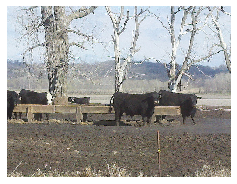

The actual caption is:
several cows gathered around a trough in a muddy field. 

The predicted captions are:
Batch size = 500: a golden horse eats grass in the pasture
Batch size = 1000: a group of dressed up people pose in front of a building


OSError: Unable to open file (unable to open file: name = './model/model_epoch78_bs2000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [292]:
I = io.imread(images[rand_train_image])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[rand_train_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:"%(actual_caption))
    
for bs in [500, 1000, 2000, 3000]:
    model.load_weights(model_directory + '/model_epoch%s_bs%s.h5'%(epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer, images_features[rand_train_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s"%(bs, img_desc))

#### Test on Validation Data

In [ ]:
rand_test_image = np.random.choice(range(len(test_captions)))

In [ ]:
I = io.imread(images[rand_test_image])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[rand_test_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:"%(actual_caption))
    
for bs in [500, 1000, 2000, 3000]:
    model.load_weights(model_directory + '/model_epoch%s_bs%s.h5'%(epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer, images_features[rand_test_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s"%(bs, img_desc))

## Discussion

### Results

In [335]:
# Understand vocab distribution to showcase teh model bias
# Note that identifying stop words and lemmatization takes a while.
word_list = []
for caption in captions:
    seq = caption.split(" ")
    word_list += seq

# Remove idiosyncracies in word usage
lemmatizer = WordNetLemmatizer()
word_list = [lemmatizer.lemmatize(word.lower()) for word in word_list 
                if word and 
                    word.lower() not in nltk.corpus.stopwords.words('english') and
                    "_" not in word]

# Calculate frequency distribution
word_list_dist = nltk.FreqDist(word_list)

man;48873
sitting;35724
two;32401
standing;28438
people;27452
woman;26082
next;24997
white;24120
holding;18867
person;16538
large;16373
group;14706
table;14381
street;14087
top;14033
small;13505
near;13348
dog;12860
black;12830
front;12738
tennis;12625
train;12476
riding;12367
cat;12152
young;11503
red;11303
plate;11252
sign;10467
playing;9817
baseball;9750
walking;9618
room;9226
blue;9118
it.;9109
bus;8757
green;8516
bathroom;8483
parked;8311
boy;8273
looking;8013
giraffe;8006
player;7946
pizza;7899
horse;7733
kitchen;7544
couple;7445
food;7411
three;7408
side;7403
girl;7378


In [415]:
# Run this line to output most frequently used vocabularies in the data set
limit = 30
word_dict = dict()
for word, frequency in word_list_dist.most_common(limit):
    print(u'{};{}'.format(word, frequency))
    word_dict[word] = frequency

man;48873
sitting;35724
two;32401
standing;28438
people;27452
woman;26082
next;24997
white;24120
holding;18867
person;16538
large;16373
group;14706
table;14381
street;14087
top;14033
small;13505
near;13348
dog;12860
black;12830
front;12738
tennis;12625
train;12476
riding;12367
cat;12152
young;11503
red;11303
plate;11252
sign;10467
playing;9817
baseball;9750


### Results & Learning

Image captionining requires implementation of deep learning methods in both computer vision and natural language processing. While doing this project, I learned to use image and word embeddings to map them into vector representations to be supplied for training. Drop-out layers are included to prevent the model from overfitting, and model tuning is performed to ensure the model achieve reasonable performance. 

<mark>Show performance metrics</mark>
Tuning helped identified that the model tends to perform better with larger batch sizes among the list of the values tested. Increasing the number of epochs is shown to help the model generate more complex vocabularies, but doing that also cause the model to overfit easily. The final model is able to produce sensible captions for the images supplied. However, there remains potential for improvements. 


### Areas of Improvement

The model is able to provide reasonable captions given the images supplied. However, there remain potential for improvements. The model appears to have difficulty distinguish objects with similar property, and the model also has a bias towards objects and captions that appear more often in the data set.

The model seems to have trouble distinguishing between objects that have subtle differences, such as sky and ocean, snowboards and surf board, etc. For instance, the model mistakes a man performing a snowboard jump as someone surfing in the ocean, presumably because the blue sky in the background bears resemblance to the color ocean, and the skis appearing in the image looks similar to a surf board. Data augmentation using data generators in the less popular objects can be applied in order to improve model accuracy on the less popular objects. 

Furthermore, there also appear to be bias in captioning due to the nature of the caption data provided. When describing people in images, the model is more likely to predict a person as a "man" even when the subject is in fact a woman. This is likely caused by the nature of the original training captions. As an evidence, in the "Word Distribution" section, you will notice that the "man" is the most popular word used after removing stop words, while women is ranked 5th. Here is the short list of words with their respective frequencies in the data set together with an example of the prediction that shows the model's gender bias. 

```
man        48873
sitting    35724
two        32401
standing   28438
people     27452
woman      26082
```

In this example, the model confuses man and woman. As shown in the list above, "man" is the more popular word.

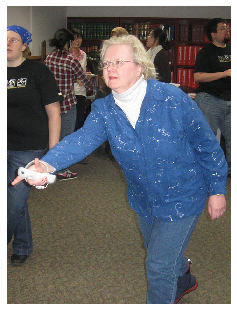

The actual caption is:
an older woman playing nintendo wii near other people 

The predicted captions is:
a man about a <unk> while hit a skateboard


In [394]:
img_idx = 3912

I = io.imread(images[img_idx])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[img_idx]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
    
model.load_weights(model_directory + '/model_epoch10_bs500.h5')
img_desc = generate_desc(model, tokenizer, images_features[img_idx], max_length)

print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s"%(actual_caption, img_desc))

In this example, the model confuses child and per. As shown in the list above, "people" or person is the more popular word.

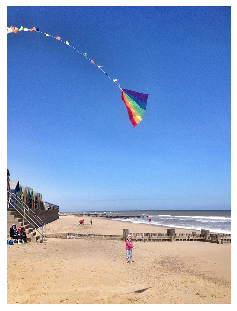

The actual caption is:
a child flying a kite on the beach. 

The predicted captions is:
a man about a kite on the air


In [358]:
img_idx = 56894

I = io.imread(images[img_idx])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[img_idx]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
    
model.load_weights(model_directory + '/model_epoch10_bs500.h5')
img_desc = generate_desc(model, tokenizer, images_features[img_idx], max_length)

print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s"%(actual_caption, img_desc))

On the other hand, "baseball" is a popular term, and we can see fairly good prediction of images related to baseballs. 

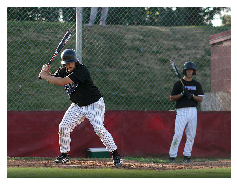

The actual caption is:
two baseball players wear black shirts and white striped pants. 

The predicted captions is:
a man swinging a bat towards a baseball


In [389]:
img_idx = 88870

I = io.imread(images[img_idx])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[img_idx]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
    
model.load_weights(model_directory + '/model_epoch10_bs500.h5')
img_desc = generate_desc(model, tokenizer, images_features[img_idx], max_length)

print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s"%(actual_caption, img_desc))

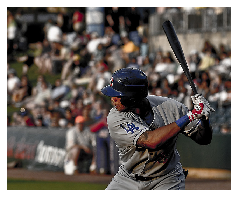

The actual caption is:
a lost angeles baseball player stands at bat while people look on. 

The predicted captions is:
a man swinging a bat towards a baseball


In [388]:
img_idx = 18728

I = io.imread(images[img_idx])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[img_idx]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
    
model.load_weights(model_directory + '/model_epoch10_bs500.h5')
img_desc = generate_desc(model, tokenizer, images_features[img_idx], max_length)

print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s"%(actual_caption, img_desc))

One future improvement is to upsample the female images and captions in the data set to improve the model's ability to recognize female. In addition, in the process of image labeling, the generic use of "man" when both genders appear should be avoided to help model better understand the gender differences. 

The categorical loss measure for model accuracy is not a good measure of the model performance. While the model performance improves with categorical accuracy, at a low loss value, the model has tendency of overfitting, producing vocabularies that do not fit well together as a sentence. In summary, the loss metric measures categorical accuracy of the word prediction, but it fails to account for the readability of the content. I have tested out the use of BLEU score to measure sentence similarity, but it fails to account for the sementic similarity of the predicted caption and actual caption. In addition, due to the difficulty with the caption learning task in itself, the scale BLEU score provides fails to provide meaningful comparison across models. For instance, one might argue that the predicted caption in the following example "a baby giraffe eating leaves on a meadow" is a good approximation of the original one "A giraffe that is eating some leaves off of a tree". However, a BLEU score of $1.39e^{-231}$ is given.

In [342]:
result_bleu = nltk.translate.bleu_score.sentence_bleu("A giraffe that is eating some leaves off of a tree.", 
                                                      "a baby giraffe eating leaves on a meadow ")
print("Resulting BLEU-4 score is %s"%(result_bleu))

Resulting BLEU score is 1.3926576473519284e-231


Lastly, I was unable to identify a way to perform grid search for hyperparameter tuning when `fit_generator` is used. In addition, my comptuation resource is limited. Therefore, I used a `for` loops for testing the model with different batch sizes. If time and resource permit, I will also tune drop out rate, maximum sentence length, word frequency cut-off values (currently none), etc.

-----

Random image generator to help me find examples:

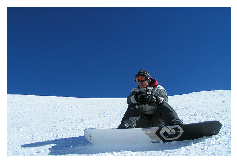

The actual caption is:
the snowboarder sits in the snow with his board attached to his feet. 

The predicted captions is:
a man flies a kite on the beach.

The image index is 1871


In [440]:
img_idx = np.random.choice(range(len(test_captions)))

I = io.imread(images[img_idx])
plt.imshow(I); plt.axis('off'); plt.show()

actual_caption = captions[img_idx]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
    
model.load_weights(model_directory + '/model_epoch50_bs500.h5')
img_desc = generate_desc(model, tokenizer, images_features[img_idx], max_length)

print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s.\n\nThe image index is %s"%(actual_caption, 
                                                                                              img_desc,
                                                                                              img_idx))

----

Link to Youtube Video: <mark>link</mark>